## CarND Project 5 - Vehicle Tracking

### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [70]:
# all necessary imports in one place
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import time
from PIL import Image
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import pickle


from classroom_functions import *

# For the impatient: Here's a [link to my video result](https://youtu.be/UeemJChbT1M) !


## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

Found 8792 vehicles and 8968 non-vehicles


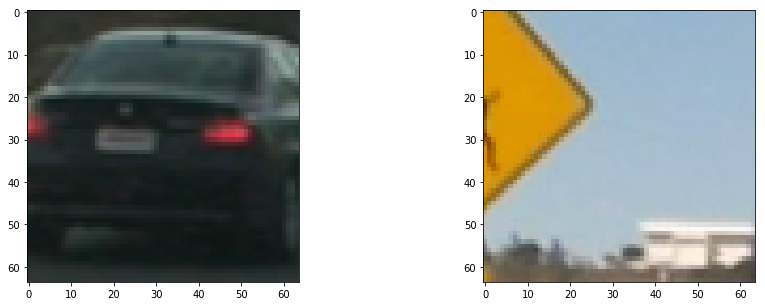

In [3]:
vs = glob.glob('data/vehicles/*/*.png')
nvs = glob.glob('data/non-vehicles/*/*.png')
print('Found {} vehicles and {} non-vehicles'.format(len(vs),len(nvs)))

v_ind = np.random.randint(0, len(vs))
nv_ind = np.random.randint(0, len(nvs))

v_image = mpimg.imread(vs[v_ind])
nv_image = mpimg.imread(nvs[nv_ind])
fig, axarr = plt.subplots(1,2,figsize=(15,5))
axarr[0].imshow(v_image)
axarr[1].imshow(nv_image)

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

The example below shows the `YCrCb` color space image (Y channel only) and the corresponding HOG features using the parameters `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

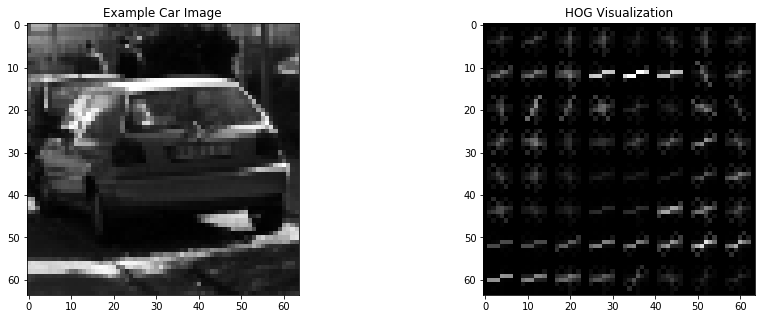

In [21]:
v_ind = np.random.randint(0, len(vs))
image = mpimg.imread(vs[v_ind])
ycryb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(ycryb[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(ycryb[:,:,0],cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters, but ended up using the original setting using the parameters `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`. My decision process mostly relied on training SVCs (usign the code below) and comparing the resulting training errors.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

As classifier, I trained a linear SVM using YCrCb 3-channel HOG features along with spatially binned color and histograms of color in the feature vector. I tried severeal color spaces combined with or without color features, but this configuration resulted in the best test error and seemed to work well with the rest of the processing.

For SVM training, first, I extract the features. Then I pass the resulting feature vectors to a scaler for normalization. Finally, I shuffle all the data before splitting it into training and test sets.

I also tried using an SVM with a radial basis function kernel as classifier. This worked quite well and provided good results both in the test set error and for further steps in the processing pipeline. However, it has the drawback of its  increased computational complexity in comparison with the linear SVM.
Therefore, in the end, I chose the linear variant to complete the rest of the project.

The code fore the SVM training can be seen in the next cells.

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [720-6*64, None] # Min and max in y to search in slide_window()

vs = glob.glob('data/vehicles/*/*.png')
nvs = glob.glob('data/non-vehicles/*/*.png')
print('Found {} vehicles and {} non-vehicles'.format(len(vs),len(nvs)))

Found 8792 vehicles and 8968 non-vehicles


In [3]:
t=time.time()
v_features = extract_features(vs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
nv_features = extract_features(nvs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((v_features, nv_features))
X.astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

52.9 Seconds to extract features...


In [4]:
# Define the labels vector
y = np.hstack((np.ones(len(v_features)), np.zeros(len(nv_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
# Shuffle the data
scaled_X, y = shuffle(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [5]:
# Use a linear SVC 
svc = LinearSVC()
# Or use a SVC with a radial basis function kernel
# svc = SVC(kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

13.56 Seconds to train SVC...
Test Accuracy of SVC =  0.987


In [29]:
# Persistence operations for the SVC classifier and the Scaler

type = 'linear'
# type = 'rbf'
load = True
save = False

filename = 'svc_'+type+'.p'
scaler_filename = 'scaler.p'

# Save Scaler to disk
if save:
    with open(scaler_filename, 'wb') as file:
        pickle.dump(obj=X_scaler, file=file)
    # Save SVC to disk
    with open(filename, 'wb') as file:
        pickle.dump(obj=svc, file=file)

# Load the SCV
if load:
    with open(filename, "rb") as file:
        svc = pickle.load(file=file)
    with open(scaler_filename, "rb") as file:
        X_scaler = pickle.load(file=file)   

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search window positions in three different scales.
- The first scale was chosen so that it would include more or less complete vehicles relatively close to the camera. I restricted the window search to regions in the image below the horizon. I also excluded the lowermost part of the image which mostly shows the hood of the car. Since this is a relatively large scale that is not as computationally intensive, I decided to use a relatively large overlap of 0.75 to produce robust results.
- The second scale was chosen so that it can recognize cars that are slightly further away and thus appear smaller in image space. Again, I restricted the region to search in this scale to below the horizon. Also, I excluded the lowest parts of the image, since cars this close would appear larger than this scale would recoginize. To reduce computational demands of this scale I also reduced the ovelap to 0.5.
- The third and final layer searches in the smallest scale for vehicles that are quite far ahead. Again, the search region is further restricted.

The code in the next cell and the following images illustrate the final serach windows.

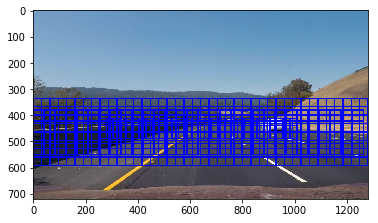

In [69]:
def get_windows(shape):
    ymax = shape[0]
    xmax = shape[1]
    size1 = int(xmax/10) # 128
    size2 = int(xmax/15) # 85
    size3 = int(xmax/25) # 51
    windows1 = slide_window(shape, x_start_stop=[None, None], 
                           y_start_stop=[int(ymax-3*size1), int(ymax-1.5*size1)], 
                           xy_window=(size1, size1), xy_overlap=(0.75, 0.75))

    windows2 = slide_window(shape, x_start_stop=[None, None], 
                           y_start_stop=[int(ymax-8*size2/2), int(ymax-4*size2/2)], 
                           xy_window=(size2, size2), xy_overlap=(0.5, 0.5))
    
    windows3 = slide_window(shape, x_start_stop=[size3*5, xmax-size3*5], 
                           y_start_stop=[int(ymax-12*size3/2), int(ymax-9*size3/2)], 
                           xy_window=(size3, size3), xy_overlap=(0.5, 0.5))

    return windows1+windows2+windows3


image = mpimg.imread('test_images/test3.jpg')
img = image

windows = get_windows(img.shape)

window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=3)                    
plt.imshow(window_img)

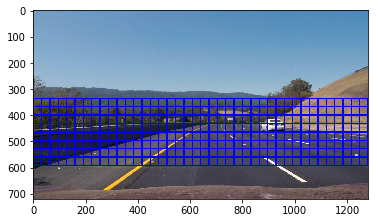

In [67]:
# largest scale

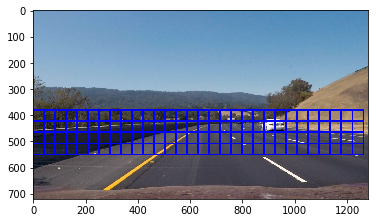

In [66]:
# medium scale

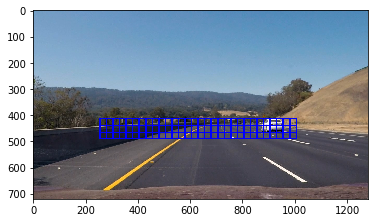

In [65]:
# smallest search scale

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

As stated above, I searched on three scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector. I did not perform a grid search for all parameters but I performed a fair amout of experiments with different parameter settings and evaluated the results qualitatively. These final settings provided a robust result.

The next cell illustrates the performance of the classifier combined with the sliding window search on the test images.
The cell after that illustrated the next step in the pipeline, namely the creation of a heatmap, thresholding and labeling the individual cars. 

0.66 Seconds to predict single sample...
0.62 Seconds to predict single sample...
0.61 Seconds to predict single sample...
0.62 Seconds to predict single sample...
0.63 Seconds to predict single sample...
0.61 Seconds to predict single sample...


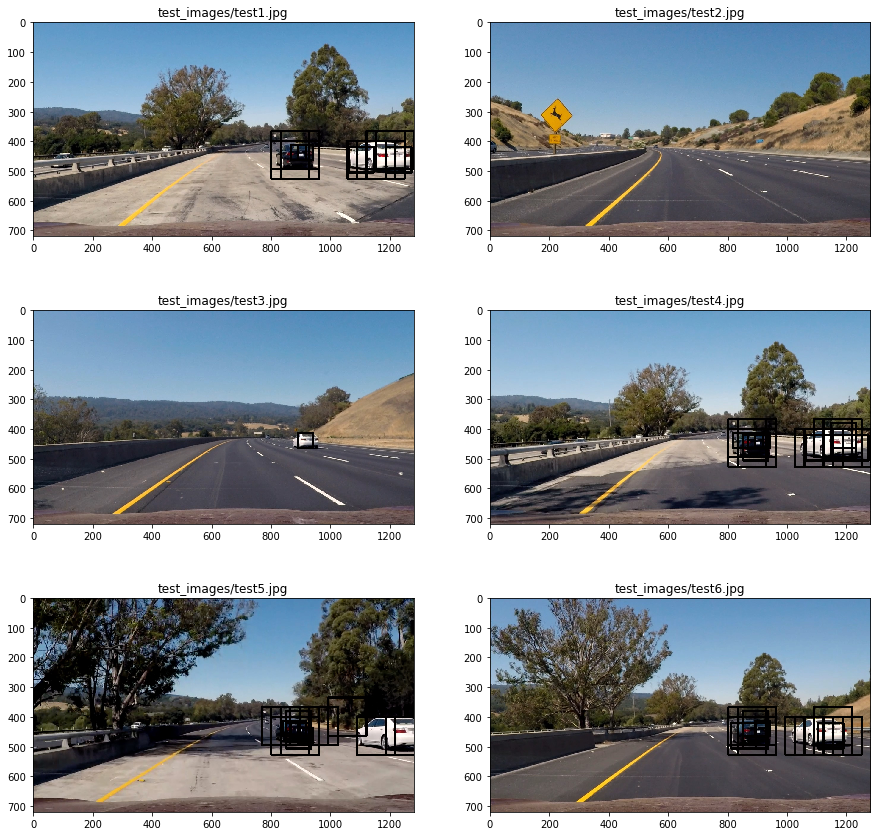

In [48]:
test_images = glob.glob('test_images/test*.jpg')

fig, axarr = plt.subplots(3,2,figsize=(15,15))

for i, test_image in enumerate(test_images):
    # Check the prediction time for a single sample
    t=time.time()

    # Careful, loading from .jpg
    image = mpimg.imread(test_image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    
#     img = cv2.resize(image, (int(1280/2), int(720/2)))
    img = image
#     print(img)
    img = img.astype(np.float32)/255
    draw_image = np.copy(img)

    
    windows = get_windows(img.shape)

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to predict single sample...')

    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)                    

    axarr[int(i/2),i%2].imshow(window_img)
    axarr[int(i/2),i%2].set_title(test_image)

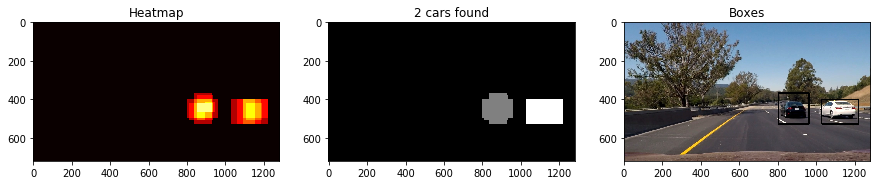

In [49]:
# Careful, loading from .jpg
image = mpimg.imread('test_images/test6.jpg')
img = image

img = img.astype(np.float32)/255
heatmap = np.zeros(img.shape[0:2])

windows = get_windows(img.shape)

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# for idx, boxlist in enumerate(hot_windows):
add_heat(heatmap, hot_windows)
    
threshold = 1 #2
final_map = apply_threshold(heatmap, threshold)
labels = label(final_map)

# Draw bounding boxes on a copy of the image
draw_img, _ = draw_labeled_bboxes(np.copy(img), labels)

# Plot the examples
fig, axarr = plt.subplots(1,3,figsize=(15,7))
axarr[0].imshow(final_map, cmap='hot')
axarr[0].set_title('Heatmap')
axarr[1].imshow(labels[0], cmap='gray')
axarr[1].set_title('{} cars found'.format(labels[1]))
axarr[2].imshow(draw_img, cmap='gray')
axarr[2].set_title('Boxes')

---

# Video Processing

In [59]:

def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

# A simple class to detect vehicles in the current frame
# while keeping track of the sliding window search from the last 5 frames
# as well as the bounding boxes of the last frame
class Detector:
    def __init__(self):
        self.hot_windows_list = []
        self.windows = get_windows((720,1280))
        self.heatmap = []
        self.bboxes = []
        return
    
    # Main processing method
    def process_frame(self, image, scale_image=True):
        # adjust the image scale coming form the video
        if scale_image:
            image = image.astype(np.float32)/255
        
        # get hot_windows from image
        hot_windows = search_windows(image, self.windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

        # append new hot_windows to the ones from previous 5 frames
        self.hot_windows_list.append(hot_windows)

        # create heatmap from 6 last frames combined
        heatmap = np.zeros(image.shape[0:2])
        for idx, boxlist in enumerate(self.hot_windows_list):
            add_heat(heatmap, boxlist)
        # add additional heat from the last
        # known bounding box locations
        for bbox in self.bboxes:
            add_heat(heatmap, boxlist)
        
        # threshold and find labels
        threshold = 2
        final_map = apply_threshold(heatmap, threshold)
        # save heatmap (only for visualization)
        self.heatmap = final_map
        labels = label(final_map)
        
        # visualize heatmap/labels for video
        draw_img1 = np.stack((heatmap,heatmap,heatmap),axis=2)*255
        draw_img1, bboxes = draw_labeled_bboxes(draw_img1, labels)
        # save bounding box locations
        self.bboxes = bboxes

        # draw resulting bounding boxes onto image
        draw_img2, _ = draw_labeled_bboxes(image, labels)
        draw_img2 = draw_img2*255
        
        # show final result and heatmap next to one another
        final_draw_image = concat_images(draw_img2,draw_img1)
        
        # remove 6th (=too old) hot_windows from saved frames
        if len(self.hot_windows_list) > 5:
            self.hot_windows_list.pop(0)
            
        return final_draw_image
    
    def process_and_visualize(self, image, scale_image=True):
        annotated = self.process_frame(image, scale_image)
        
        return annotated[:,0:1280,:], self.heatmap

In [55]:
# Class to write video frames to disk individually
# class Detector:
#     def __init__(self):
#         self.hot_windows_list = []
#         self.i = 0
#         return
#     def process_frame(self,image):
#         filename = 'project_video/'+ str(self.i)+'.png'
#         mpimg.imsave(filename, image)
#         self.i = self.i+1
#         return image

# Class to crop to half of the output
# from the detector in the cell above
# class Detector:
#     def __init__(self):
#         self.hot_windows_list = []
#         self.i = 0
#         return
#     def process_frame(self,image):
#         return image[:,0:1280,:]

In [56]:
# filename = 'test_video.mp4'
# filename = 'test_video_short.mp4'
# filename = 'project_video_short.mp4'
filename = 'project_video_result.mp4'
output_filename = filename[:-4] + '_result.mp4'

detector = Detector()

clip = VideoFileClip(filename)
project_clip = clip.fl_image(detector.process_frame)
%time project_clip.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video project_video_result_result.mp4
[MoviePy] Writing video project_video_result_result.mp4


100%|█████████▉| 1260/1261 [00:35<00:00, 35.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result_result.mp4 

CPU times: user 27.9 s, sys: 5.23 s, total: 33.1 s
Wall time: 35.9 s


### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
# Here's a [link to my video result](https://youtu.be/UeemJChbT1M) !

### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap, then thresholded that map to identify vehicle positions. I also kept track of the positions of the previous bounding boxes - resulting after the thresholding of the last frame - and added additional heat for these regions.
I then used scipys `label()` functionality to identify connected components in the heatmap.  Assuming each component corresponded to one vehicle, I constructed bounding boxes to cover the area of each one.

#### Here are six frames and their corresponding heatmaps (right: heatmap before thresholding, left: resulting bounding boxes after thresholding)

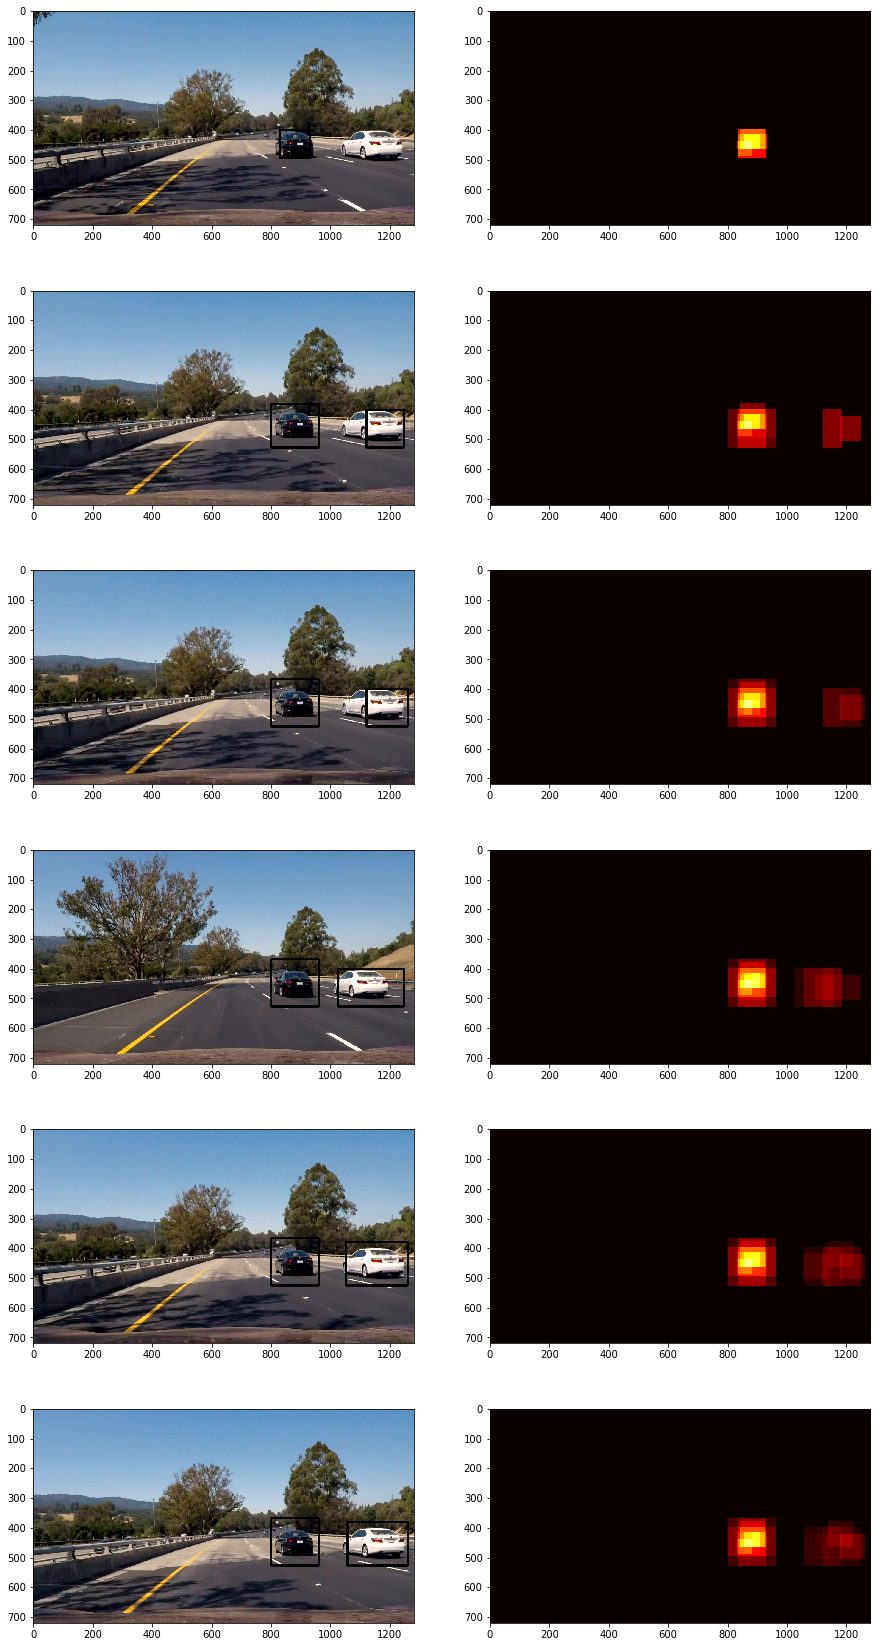

In [72]:
imagefiles = glob.glob('project_video/*.png')

detector = Detector()

rows = 6
fig, axarr = plt.subplots(6,2, figsize=(15,5*rows))

i=0
for imagefile in imagefiles[20:20+rows]:
    image = mpimg.imread(imagefile)
    image = image[:,:,0:3].astype(np.float32)

    annotated, heatmap = detector.process_and_visualize(image, scale_image=False)
    axarr[i,0].imshow(annotated)
    axarr[i,1].imshow(heatmap, cmap='hot')
    i=i+1

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames and the resulting bounding boxes drawn onto the last frame in the series:

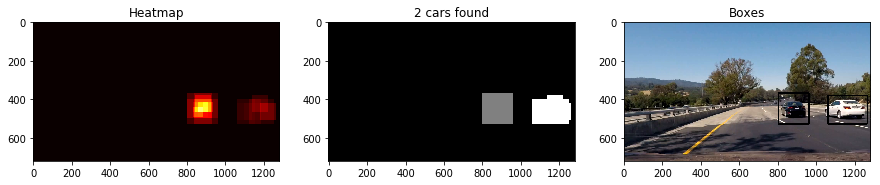

In [73]:
labels = label(heatmap)

fig, axarr = plt.subplots(1,3,figsize=(15,7))
axarr[0].imshow(heatmap, cmap='hot')
axarr[0].set_title('Heatmap')
axarr[1].imshow(labels[0], cmap='gray')
axarr[1].set_title('{} cars found'.format(labels[1]))
axarr[2].imshow(annotated, cmap='gray')
axarr[2].set_title('Boxes')

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

##### Approach and Tekniques
For this project, I followed the guiding principles conveyed in the classroom lessons pretty closely. I extracted HOG and color features, trained a linear SVM classifier based on normalized features. I used a sliding window technique, heatmap creation and aggregation over several frames followed by thresholding to determine likely vehicle locations and labelled these using a connected components algorithm.
All in all, I was surprised to find all the components working quite well, relatively fast.
One important detail that hat I did not investigate much further is real-time performance (e.g. the frame rate the algorithm can handle). Which brings me to the next point:

##### Failure Conditions and Possible Improvements
The current implementation is pretty computationall intensive. My machine could process about 1.5 frames per second using such large time steps would most likely not work for the heatmap aggregation pipeline. Certainly, the algorithm could be computationally optimized. Also, I could imagine a downsampling of both the training data for the SVC and the images to be processed by a factor of 2 to speed up the processing. It remains to be seen what loss in quality would ensue.

Also, I can think of a few difficult scenarios and possible improvements for the algorithm currently:
- As can be seen in some of the sample images (i.e. the third image in the series of 6 above), the classifier seems to recognize car backsides a lot better than car-sides. I would suppose such a tendency to originat from not quite balanced training data, but also because a car-side might not have as characteristic features car-backside. Increasing the amount of car-side data in the training sets might help in this case.
- The bounding boxes currently fitted are still quite 'jumpy'. This could be improved by adding another layer of filtering on top of the current pipeline.
- The training set only contains day-time images. Night time drives could not be analyzed using the current classifier.

##### Further study
As a last thought: For this project we took a classical computer vision approach to vehicle detection. I am quite certain that an approach using deep learning might lead to qualitatively better results and will probably investigate a bit further in this direction before the start of the next term.
